In [18]:
import gymnasium as gym
import cookiedisaster
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)

SEED=2
np.random.seed(SEED)

env = gym.make('cookiedisaster/GridWorld-v0')

2.2.2


In [43]:
env.reset(seed=SEED) 

({'agent': {'pos': 4, 'vel': 0.0},
  'cookie': {'pos': 0.8451834911475694, 'time': 5}},
 {'distance': 3.1548165088524307, 'steps': 0})

In [44]:
# env.render()
DUMMY_STATE=env.step(0)
MAX_TIME=5*25 # 5 cookies elapse time
PUNISHMENT=-1 # may have to be adjusted

In [30]:
def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
    robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
    cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
    cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


# Actor - critic model - from chat


In [31]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.network(state)


In [32]:
input_dim = 6  # From preprocess_state function
output_dim = env.action_space.n

actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)


In [33]:
num_episodes = 10
gamma = 0.99  # Discount factor for future rewards


def train_actor_critic(env, num_episodes=10, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
    # Environment and model parameters
    input_dim = 6  # From preprocess_state function
    output_dim = env.action_space.n

    # Initialize models
    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    # Initialize optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    
    # Training loop
    episode_rewards = []  # Track rewards per episode
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            done = next_state[2]
            
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=PUNISHMENT
                # total_reward+=PUNISHMENT
                break
            count+=1
            # if count>100:
            #     print('count',count)
            #     break
            
            next_state = preprocess_state(next_state)
            
            total_reward += reward
            
            # Critic update
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state).unsqueeze(0))
            td_error = reward + gamma * next_value * (1 - int(done)) - value
            critic_loss = td_error.pow(2)
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            # Actor update
            actor_loss = -distribution.log_prob(action) * td_error.detach()
            
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            state = next_state
            
        
        episode_rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    return actor, critic, episode_rewards





In [34]:
def evaluate_policy(env, actor, num_episodes=100):
    total_rewards = 0.0

    for _ in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            if count > MAX_TIME:  # Break if max time exceeded without positive reward
                break
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            done = next_state[2]
            
            if next_state[1]>0:
                break
            
            if count>MAX_TIME:
                
                break
            count+=1
          
            
            next_state = preprocess_state(next_state)
            
            total_reward += reward

       

    average_reward = total_rewards / num_episodes
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return average_reward



In [37]:
def find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, gamma=0.99, threshold_reward=None, max_iterations=10, eval_episodes=10):
    actor_lr = initial_actor_lr
    critic_lr = initial_critic_lr
    
    best_average_reward = float('-inf')
    best_actor = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}: Training Started")
        actor, critic, _ = train_actor_critic(env, num_episodes=10, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)
        average_reward = evaluate_policy(env, actor, num_episodes=eval_episodes)
        print(f"Iteration {iteration + 1}: Average Reward = {average_reward}")
        
        # Check if the current model is the best one
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            best_actor = actor
            print("New best model found!")
            
            # Optional: Adjust learning rates based on performance, implement your strategy here
            # actor_lr *= learning_rate_decay
            # critic_lr *= learning_rate_decay
            
        # If a threshold is defined and met, stop training
        if threshold_reward is not None and average_reward >= threshold_reward:
            print(f"Desired threshold reward of {threshold_reward} achieved.")
            break
        
        # Optional: Implement additional logic to adjust training parameters or terminate early
    
    return best_actor, best_average_reward


In [38]:
best_actor, best_reward = find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, threshold_reward=-2.5, max_iterations=10)
print(f"Best average reward achieved: {best_reward}")


Iteration 1/10: Training Started
Episode 0, Total Reward: -5.784163567670691
Average Reward over 10 episodes: 0.0
Iteration 1: Average Reward = 0.0
New best model found!
Desired threshold reward of -2.5 achieved.
Best average reward achieved: 0.0


In [39]:
def test_actor_critic(env, actor, episodes=100):
    total_rewards = []
    state = env.reset()

    
    for _ in range(episodes):
        state = preprocess_state(state)  # Adjust based on your state preprocessing
        done = False
        total_reward = 0
        count = 0
        
        
      
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = actor(state_tensor)
        action = torch.argmax(q_values).item()
        next_state= env.step(action)
        reward = next_state[1]
        done = next_state[2]    
        # next_state = preprocess_state(next_state)
        state = next_state
        total_reward += reward
        
        total_rewards.append(total_reward)
    
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {episodes} episodes: {avg_reward}")
    return avg_reward


In [40]:
env=gym.make('cookiedisaster/GridWorld-v0',render_mode='human')
test_actor_critic(env, best_actor, episodes=100)
env.close()

c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Average reward over 100 episodes: -0.32913523367071407


# without epsilon greedy:

In [ ]:

SEED=2
np.random.seed(SEED)

env = gym.make('cookiedisaster/GridWorld-v0')

env.reset(seed=SEED) 
# env.render()
DUMMY_STATE=env.step(0)
MAX_TIME=5*25 # 5 cookies elapse time
PUNISHMENT=-1 # may have to be adjusted

def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
    robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
    cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
    cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.network(state)

input_dim = 6  # From preprocess_state function
output_dim = env.action_space.n

actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

num_episodes = 1000
gamma = 0.99  # Discount factor for future rewards


def train_actor_critic(env, num_episodes=10, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
    # Environment and model parameters
    input_dim = 6  # From preprocess_state function
    output_dim = env.action_space.n

    # Initialize models
    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    # Initialize optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    
    # Training loop
    action_counts = np.zeros(output_dim)
    episode_rewards = []  # Track rewards per episode
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            done = next_state[2]
            
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=PUNISHMENT
                # total_reward+=PUNISHMENT
                break
            count+=1
            # if count>100:
            #     print('count',count)
            #     break
            
            next_state = preprocess_state(next_state)
            
            total_reward += reward
            
            # Critic update
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state).unsqueeze(0))
            td_error = reward + gamma * next_value * (1 - int(done)) - value
            critic_loss = td_error.pow(2)
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            # Actor update
            actor_loss = -distribution.log_prob(action) * td_error.detach()
            
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            state = next_state
            
        
        episode_rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    return actor, critic, episode_rewards

def evaluate_policy(env, actor, num_episodes=100):
    total_rewards = 0.0
    rewards = []    
    for _ in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            if count > MAX_TIME:  # Break if max time exceeded without positive reward
                break
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            rewards.append(reward)
            done = next_state[2]
            
            if next_state[1]>0:
                break
            
            if count>MAX_TIME:
                
                break
            count+=1
          
            
            next_state = preprocess_state(next_state)
            
            
            total_reward += reward

       

    average_reward = total_rewards / num_episodes
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return average_reward, rewards

def find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, gamma=0.99, threshold_reward=None, max_iterations=10, eval_episodes=10):
    actor_lr = initial_actor_lr
    critic_lr = initial_critic_lr
    
    best_average_reward = float('-inf')
    best_actor = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}: Training Started")
        actor, critic, _ = train_actor_critic(env, num_episodes = num_episodes, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)
        average_reward, rewards = evaluate_policy(env, actor, num_episodes=eval_episodes)
        print(f"Iteration {iteration + 1}: Average Reward = {average_reward}")
        
        # Check if the current model is the best one
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            best_actor = actor
            print("New best model found!")
            
            # Optional: Adjust learning rates based on performance, implement your strategy here
            # actor_lr *= learning_rate_decay
            # critic_lr *= learning_rate_decay
            
        # If a threshold is defined and met, stop training
        if threshold_reward is not None and average_reward >= threshold_reward:
            print(f"Desired threshold reward of {threshold_reward} achieved.")
            break
        
        # Optional: Implement additional logic to adjust training parameters or terminate early
    
    return best_actor, best_average_reward, rewards

best_actor, best_reward, rewards = find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, threshold_reward=-2.5, max_iterations=num_episodes)
print(f"Best average reward achieved: {best_reward}")


# def test_actor_critic(env, actor, episodes=num_episodes):
#     total_rewards = []
#     state = env.reset()

    
#     for _ in range(episodes):
#         state = preprocess_state(state)  # Adjust based on your state preprocessing
#         done = False
#         total_reward = 0
#         count = 0
        
        
      
#         state_tensor = torch.FloatTensor(state).unsqueeze(0)
#         q_values = actor(state_tensor)
#         action = torch.argmax(q_values).item()
#         next_state= env.step(action)
#         reward = next_state[1]
#         done = next_state[2]    
#         # next_state = preprocess_state(next_state)
#         state = next_state
#         total_reward += reward
        
#         total_rewards.append(total_reward)
    
#     avg_reward = np.mean(total_rewards)
#     print(f"Average reward over {episodes} episodes: {avg_reward}")
#     return avg_reward

# env=gym.make('cookiedisaster/GridWorld-v0',render_mode='human')
# test_actor_critic(env, best_actor, episodes=num_episodes)
# env.close()


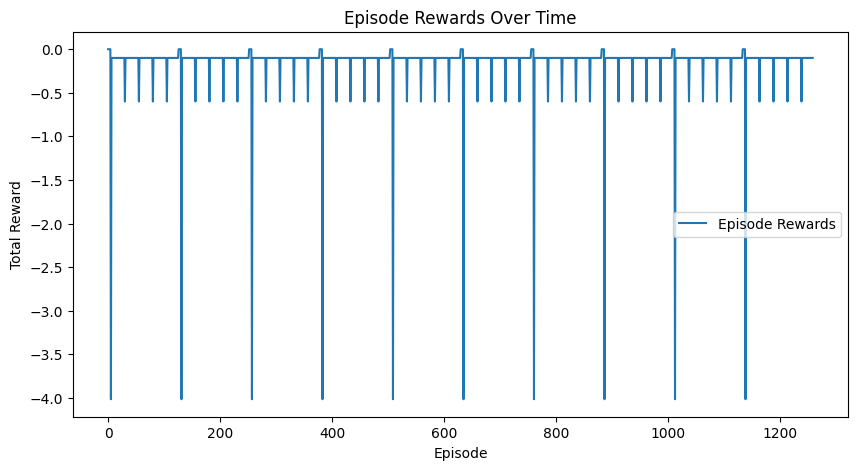

KeyboardInterrupt: 

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards Over Time')
    plt.legend()
    plt.show()

def plot_actions(env, actor, num_episodes=1):
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        actions = []
        rewards = []

        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = actor(state_tensor)
            action = torch.argmax(action_probs).item()
            actions.append(action)

            next_state= env.step(action)
            reward = next_state[1]
            rewards.append(reward)
            next_state = preprocess_state(next_state)
            state = next_state

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(actions, label='Actions Taken')
        plt.xlabel('Step')
        plt.ylabel('Action')
        plt.title('Actions Over Steps in Episode')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rewards, label='Rewards Received')
        plt.xlabel('Step')
        plt.ylabel('Reward')
        plt.title('Rewards Over Steps in Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()

def visualize_policy(actor, state_samples=500):
    action_counts = np.zeros(env.action_space.n)
    for _ in range(state_samples):
        state = env.observation_space.sample()
        state = preprocess_state(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = actor(state_tensor)
        action = torch.argmax(action_probs).item()
        action_counts[action] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(env.action_space.n), action_counts, tick_label=[f'Action {i}' for i in range(env.action_space.n)])
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.title('Action Distribution from Policy')
    plt.show()

# Example usage
plot_rewards(rewards)
plot_actions(env, best_actor, num_episodes=1)
visualize_policy(best_actor)


# with epsilon greedy:

In [31]:


SEED=2
np.random.seed(SEED)

env = gym.make('cookiedisaster/GridWorld-v0')

env.reset(seed=SEED) 
# env.render()
DUMMY_STATE=env.step(0)
MAX_TIME=5*25 # 5 cookies elapse time
PUNISHMENT=-1 # may have to be adjusted

def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
    robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
    cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
    cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.network(state)

input_dim = 6  # From preprocess_state function
output_dim = env.action_space.n

actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)


actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

num_episodes = 1000
gamma = 0.99  # Discount factor for future rewards

episode_rewards = []  # Track rewards per episode
action_counts = np.zeros(output_dim)
def train_actor_critic(env, num_episodes=10, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
    # Environment and model parameters
    input_dim = 6  # From preprocess_state function
    output_dim = env.action_space.n

    # Initialize models
    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    # Initialize optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    
    # Training loop
    
    
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0
        epsilon_start = 1.0
        epsilon_min = 0.01
        epsilon_decay = 0.995

        while not done:
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            epsilon = max(epsilon_min, epsilon_start * epsilon_decay**episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = distribution.sample()
            
            action_counts[action] += 1
            next_state= env.step(action.item())
            reward = next_state[1]
            done = next_state[2]
            
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=PUNISHMENT
                # total_reward+=PUNISHMENT
                break
            count+=1
            # if count>100:
            #     print('count',count)
            #     break
            
            next_state = preprocess_state(next_state)
            
            total_reward += reward
            
            # Critic update
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state).unsqueeze(0))
            td_error = reward + gamma * next_value * (1 - int(done)) - value
            critic_loss = td_error.pow(2)
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            # Actor update
            action = torch.tensor(action)
            actor_loss = -distribution.log_prob(action) * td_error.detach()
            
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            state = next_state
            
        
        episode_rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    return actor, critic, episode_rewards, action_counts, episode_rewards

def evaluate_policy(env, actor, num_episodes=100):
    total_rewards = 0.0
    rewards = []    
    for _ in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            if count > MAX_TIME:  # Break if max time exceeded without positive reward
                break
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            rewards.append(reward)
            done = next_state[2]
            
            if next_state[1]>0:
                break
            
            if count>MAX_TIME:
                
                break
            count+=1
          
            
            next_state = preprocess_state(next_state)
            
            
            total_reward += reward

       

    average_reward = total_rewards / num_episodes
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return average_reward, rewards

def find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, gamma=0.99, threshold_reward=None, max_iterations=10, eval_episodes=10):
    actor_lr = initial_actor_lr
    critic_lr = initial_critic_lr
    
    best_average_reward = float('-inf')
    best_actor = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}: Training Started")
        actor, critic, episode_rewards, action_counts, episode_rewards= train_actor_critic(env, num_episodes=num_episodes, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)
        average_reward, rewards = evaluate_policy(env, actor, num_episodes=eval_episodes)
        print(f"Iteration {iteration + 1}: Average Reward = {average_reward}")
        
        # Check if the current model is the best one
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            best_actor = actor
            print("New best model found!")
            
            # Optional: Adjust learning rates based on performance, implement your strategy here
            # actor_lr *= learning_rate_decay
            # critic_lr *= learning_rate_decay
            
        # If a threshold is defined and met, stop training
        if threshold_reward is not None and average_reward >= threshold_reward:
            print(f"Desired threshold reward of {threshold_reward} achieved.")
            break
        
        # Optional: Implement additional logic to adjust training parameters or terminate early
    
    return best_actor, best_average_reward, rewards

best_actor, best_reward, rewards = find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, threshold_reward=-2.5, max_iterations=num_episodes)
print(f"Best average reward achieved: {best_reward}")


# def test_actor_critic(env, actor, episodes=num_episodes):
#     total_rewards = []
#     state = env.reset()

    
#     for _ in range(episodes):
#         state = preprocess_state(state)  # Adjust based on your state preprocessing
#         done = False
#         total_reward = 0
#         count = 0
        
        
      
#         state_tensor = torch.FloatTensor(state).unsqueeze(0)
#         q_values = actor(state_tensor)
#         action = torch.argmax(q_values).item()
#         next_state= env.step(action)
#         reward = next_state[1]
#         done = next_state[2]    
#         # next_state = preprocess_state(next_state)
#         state = next_state
#         total_reward += reward
        
#         total_rewards.append(total_reward)
    
#     avg_reward = np.mean(total_rewards)
#     print(f"Average reward over {episodes} episodes: {avg_reward}")
#     return avg_reward

# env=gym.make('cookiedisaster/GridWorld-v0',render_mode='human')
# test_actor_critic(env, best_actor, episodes=num_episodes)
# env.close()


c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Iteration 1/1000: Training Started
Episode 0, Total Reward: 0


C:\Users\shani\AppData\Local\Temp\ipykernel_9016\1716686078.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)


Episode 100, Total Reward: 0
Episode 200, Total Reward: -2.0
Episode 300, Total Reward: -2.5
Episode 400, Total Reward: -2.5
Episode 500, Total Reward: -1.0
Episode 600, Total Reward: -2.5
Episode 700, Total Reward: -2.5
Episode 800, Total Reward: -2.5
Episode 900, Total Reward: -2.5
Average Reward over 10 episodes: 0.0
Iteration 1: Average Reward = 0.0
New best model found!
Desired threshold reward of -2.5 achieved.
Best average reward achieved: 0.0


In [26]:
len(episode_rewards)
episode_rewards

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [30]:
plt.plot(range(1, len(rewards) + 1), rewards, label="Episode Reward")  # Original rewards

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes vs Rewards (Original & Moving Average)')
plt.grid(True)
plt.legend()  # Add legend for clarity
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

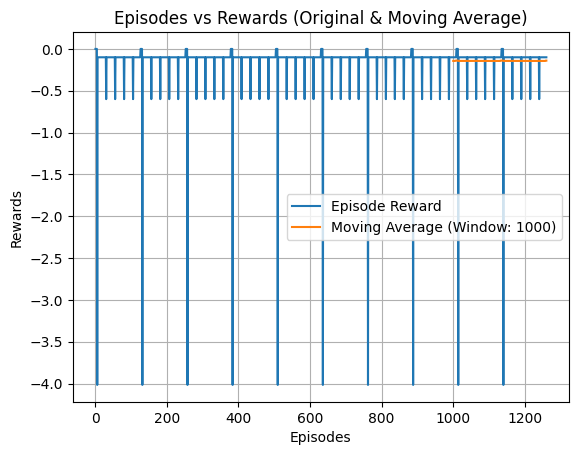

In [6]:
import matplotlib.pyplot as plt

def moving_average(rewards, window_size):
  """
  Calculates the moving average of a list of rewards.

  Args:
      rewards: List of rewards per episode.
      window_size: Number of episodes for the moving average window.

  Returns:
      List of moving average rewards.
  """
  moving_averages = []
  for i in range(len(rewards)):
    if i < window_size:
      # Calculate average for initial episodes (less than window size)
      moving_averages.append(sum(rewards[:i+1]) / (i+1))
    else:
      # Calculate moving average using window
      moving_averages.append(sum(rewards[i-window_size+1:i+1]) / window_size)
  return moving_averages

# Assuming rewards is the list containing your episode rewards
window_size = 1000
smoothed_rewards = moving_average(rewards, window_size)

plt.plot(range(1, len(rewards) + 1), rewards, label="Episode Reward")  # Original rewards
plt.plot(range(window_size, len(rewards) + 1), smoothed_rewards[window_size - 1:], label=f"Moving Average (Window: {window_size})")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes vs Rewards (Original & Moving Average)')
plt.grid(True)
plt.legend()  # Add legend for clarity
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards Over Time')
    plt.legend()
    plt.show()

def plot_actions(env, actor, num_episodes=1):
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        actions = []
        rewards = []

        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = actor(state_tensor)
            action = torch.argmax(action_probs).item()
            actions.append(action)

            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            next_state = preprocess_state(next_state)
            state = next_state

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(actions, label='Actions Taken')
        plt.xlabel('Step')
        plt.ylabel('Action')
        plt.title('Actions Over Steps in Episode')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rewards, label='Rewards Received')
        plt.xlabel('Step')
        plt.ylabel('Reward')
        plt.title('Rewards Over Steps in Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()

def visualize_policy(actor, state_samples=500):
    action_counts = np.zeros(env.action_space.n)
    for _ in range(state_samples):
        state = env.observation_space.sample()
        state = preprocess_state(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = actor(state_tensor)
        action = torch.argmax(action_probs).item()
        action_counts[action] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(env.action_space.n), action_counts, tick_label=[f'Action {i}' for i in range(env.action_space.n)])
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.title('Action Distribution from Policy')
    plt.show()

# Example usage
plot_rewards(rewards)
plot_actions(env, best_actor, num_episodes=1)
visualize_policy(best_actor)


In [6]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.distributions import Categorical
# import gymnasium as gym
# import cookiedisaster
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# print(torch.__version__)

# SEED=2
# np.random.seed(SEED)

# env = gym.make('cookiedisaster/GridWorld-v0')
#   # Assuming the environment code is saved as CookieDisasterEnv.py

# class Actor(nn.Module):
#     def __init__(self, input_dim, action_dim):
#         super(Actor, self).__init__()
#         # Layers for extracting features from the state
#         self.shared_layers = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU()
#         )
#         # Actor-specific layer for policy prediction
#         self.action_layer = nn.Linear(128, action_dim)

#     def forward(self, state):
#         # state = torch.from_numpy(state).float()
#         features = self.shared_layers(state)
#         action_probs = torch.softmax(self.action_layer(features), dim=-1)
#         return action_probs

# class Critic(nn.Module):
#     def __init__(self, input_dim):
#         super(Critic, self).__init__()
#         # Layers for extracting features from the state and estimating value
#         self.shared_layers = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU()
#         )
#         self.value_layer = nn.Linear(128, 1)

#     def forward(self, state):
#         # state = torch.from_numpy(state).float()
#         features = self.shared_layers(state)
#         state_value = self.value_layer(features)
#         return state_value

# class ActorCritic(nn.Module):
#     def __init__(self, input_dim, action_dim):
#         super(ActorCritic, self).__init__()
#         self.actor = Actor(input_dim, action_dim)
#         self.critic = Critic(input_dim)

#     def forward(self, state):
#         action_probs = self.actor(state)
#         state_value = self.critic(state)
#         return action_probs, state_value
    
# def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
#     """Normalizes a value between a given range to another range."""
#     return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

# def preprocess_state(state):
#     # Extract numerical values from the state, handling nested structures
#     agent_info = state[0]['agent']
#     cookie_info = state[0]['cookie']
#     distance = state[1]['distance']
#     steps = state[1]['steps']  # Potentially useful for tracking progress

#     # Normalize values for consistency
#     robot_pos = normalize(agent_info['pos'], 0, 10)
#     robot_vel = normalize(agent_info['vel'], -7, 7)
#     cookie_pos = normalize(cookie_info['pos'], 0, 10)
#     cookie_time = normalize(cookie_info['time'], 0, 5)
#     normalized_distance = normalize(distance, 0, 10)

#     # Create the flat state vector, potentially including steps
#     flat_state = np.array([robot_pos, robot_vel, cookie_pos, cookie_time, normalized_distance])  # Consider adding steps if relevant

#     return flat_state

# def compute_returns(next_value, rewards, masks, gamma=0.99):
#     """Calculates discounted returns for each step in the episode-"""

#     R = next_value
#     returns = []
#     for step in reversed(range(len(rewards))):
#         R = rewards[step] + gamma * R * masks[step]
#         returns.insert(0, R)
#     return returns

# def train(env, policy, optimizer, epochs=1000, gamma=0.99):

#     for epoch in range(epochs):
#         raw_state = env.reset()  # Get the initial state
#         state = preprocess_state(raw_state)  # Preprocess the state

#         done = False
#         while not done:
#             state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Convert to tensor, then add batch dimension
#             action_prob, state_value = policy.forward(state_tensor)
#             # action_prob, state_value = policy.forward(state.unsqueeze(0))  # Convert to tensor and add batch dimension
#             dist = torch.distributions.Categorical(action_prob)
#             action = dist.sample()

#             raw_next_state, reward, done, _ = env.step(action.item())  # Get next state, reward, done flag, and additional info (ignored)
#             next_state = preprocess_state(raw_next_state)  # Preprocess the next state

#             policy.log_probs.append(dist.log_prob(action))
#             policy.state_values.append(state_value)
#             policy.rewards.append(torch.tensor([reward], dtype=torch.float))

#             state = next_state  # Update state for the next iteration

#         if done:  # Calculate returns after episode ends
#             next_state = np.zeros(state.shape)  # Set terminal state to zero vector
#             next_value, _ = policy.forward(torch.FloatTensor(next_state).unsqueeze(0))
#             returns = compute_returns(next_value, policy.rewards, [1.0 - done])  # No mask needed for final state

#         # Concatenate and convert data to tensors for calculations
#         log_probs = torch.cat(policy.log_probs)
#         returns = torch.cat(returns).detach()
#         state_values = torch.cat(policy.state_values)

#         # Calculate advantages and losses
#         advantage = returns - state_values
#         actor_loss = -(log_probs * advantage.detach()).mean()
#         critic_loss = advantage.pow(2).mean()

#         # Update model parameters
#         optimizer.zero_grad()
#         (actor_loss + critic_loss).backward()
#         optimizer.step()

#         # Clear storage for the next episode
#         policy.log_probs = []
#         policy.state_values = []
#         policy.rewards = []

# if __name__ == "__main__":
#     env = gym.make('cookiedisaster/GridWorld-v0', render_mode='human')
#     policy = ActorCritic(env.observation_space.shape[0], env.action_space.n)
#     optimizer = optim.Adam(policy.parameters(), lr=1e-2)
#     train(env, policy, optimizer)
#     env.close()


2.2.2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 3x128)